In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import matplotlib
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats
import xgboost as xgb
from scipy.stats import norm
#from pyglmnet import GLM # Marco: need to understand how to install this 
from sklearn.preprocessing import StandardScaler

%matplotlib inline

sns.set_style("whitegrid")
# sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
#plt.style.use('ggplot')

In [2]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

In [3]:
target = train['SalePrice']
target_log = np.log1p(train['SalePrice'])

In [4]:
# drop target variable from train dataset
train = train.drop(["SalePrice"], axis=1)

In [5]:
data = pd.concat([train, test], ignore_index=True)

In [6]:
# save all categorical columns in list
categorical_columns = [col for col in data.columns.values if data[col].dtype == 'object']

# dataframe with categorical features
data_cat = data[categorical_columns]
# dataframe with numerical features
data_num = data.drop(categorical_columns, axis=1)

In [7]:
from scipy.stats import skew
data_num_skew = data_num.apply(lambda x: skew(x.dropna()))
data_num_skew = data_num_skew[data_num_skew > .75]

# apply log + 1 transformation for all numeric features with skewnes over .75
data_num[data_num_skew.index] = np.log1p(data_num[data_num_skew.index])

#### #### Handing Missing Values in Numerical Columns

In [8]:
data_len = data_num.shape[0]

# check what is percentage of missing values in categorical dataframe
for col in data_num.columns.values:
    missing_values = data_num[col].isnull().sum()
    #print("{} - missing values: {} ({:0.2f}%)".format(col, missing_values, missing_values/data_len*100)) 
    
    # drop column if there is more than 50 missing values
    if missing_values > 50:
        #print("droping column: {}".format(col))
        data_num = data_num.drop(col, axis = 1)
    # if there is less than 50 missing values than fill in with median valu of column
    else:
        #print("filling missing values with median in column: {}".format(col))
        data_num = data_num.fillna(data_num[col].median())
    

#### handling missing values in categorical columns

In [9]:
data_len = data_cat.shape[0]

# check what is percentage of missing values in categorical dataframe
for col in data_cat.columns.values:
    missing_values = data_cat[col].isnull().sum()
    #print("{} - missing values: {} ({:0.2f}%)".format(col, missing_values, missing_values/data_len*100)) 
    
    # drop column if there is more than 50 missing values
    if missing_values > 50:
        print("droping column: {}".format(col))
        data_cat.drop(col, axis = 1)
    # if there is less than 50 missing values than fill in with median valu of column
    else:
        #print("filling missing values with XXX: {}".format(col))
        #data_cat = data_cat.fillna('XXX')
        pass
    


droping column: Alley
droping column: BsmtQual
droping column: BsmtCond
droping column: BsmtExposure
droping column: BsmtFinType1
droping column: BsmtFinType2
droping column: FireplaceQu
droping column: GarageType
droping column: GarageFinish
droping column: GarageQual
droping column: GarageCond
droping column: PoolQC
droping column: Fence
droping column: MiscFeature


In [10]:
data_cat_dummies = pd.get_dummies(data_cat)

In [11]:
data = pd.concat([data_num, data_cat_dummies], axis=1)

In [12]:
train = data.iloc[:len(train)-1]
train = train.join(target_log)

test = data.iloc[len(train)+1:]

In [13]:
# remove Id and target variable
X_train = train[train.columns.values[1:-1]]
y_train = train[train.columns.values[-1]]

# remove Id
X_test = test[test.columns.values[1:]]

#### Random Forest

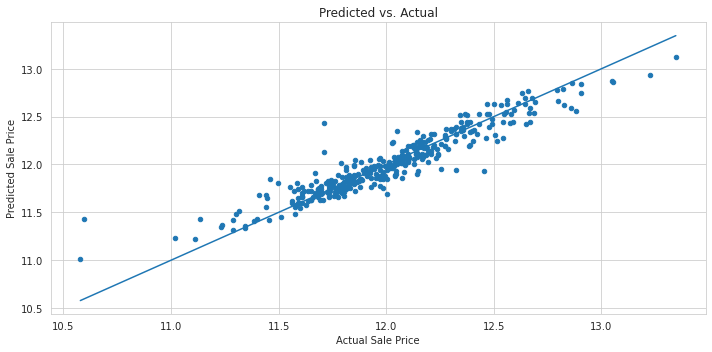

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score


%matplotlib inline

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train )
model_rf = RandomForestRegressor(n_estimators=500, n_jobs=-1)

model_rf.fit(X_train1, y_train1)
rf_pred = model_rf.predict(X_test1)

plt.figure(figsize=(10, 5))
plt.scatter(y_test1, rf_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

In [15]:
model_rf.fit(X_train,y_train)
rf_pred_log = model_rf.predict(X_test)

In [16]:
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(rf_pred_log)})

In [17]:
submission.to_csv("random_forest.csv", index=False)